# Escience Course Report

## Group 1: Arctic - SCHMARTIC: SCHool of Model evaluation of AeRosol-Cloud inTeractions Important for Climate

### Stefan Pfaller
### stefan.pfaller@gmail.com
### eScience Course 2022, Tjärnö
### 22 November, 2022
### Assistant: Sara Blichner

## 0. Abstract

The processes leading up to the formation of clouds is quite complex, with many cascading effects. This calls into question the accuracy of models that incorporate aerosol species that for the basis of these processes. This is done by comparing NorESM values to measured observations at the Zeppelin station in Ny-Ålesund. Sulphate and sea salt's role as aerosol sources are overestimated but do not lead to enough particles being present. This is due to the daily average concentrations of each species not being high enough, particularly in high concentration days. A decrease in particles present would change the characteristics of clouds in the model changing the overall radiative balance for the Arctic.

## 1. Introduction

(* Indicate where I will be adding sources, having issues importing them.)

Predicting Earth's changing climate is a vital need that requires models providing accurate and trustworthy expectations of future conditions, so that actions may be taken to avoid adverse scenarios * . This is most true in the Artic where temperatures have been increasing at up to three times the average global rates encouraged by positive feedbacks * . Many of these are positive and leading to increased warming, for example increased temperatures leading to lower sea ice cover, causing lower average surface albedo, in turn leading to further warming via decreased reflected solar radiation * . Some are negative feedbacks and could help the climate remain in a more "normal" state by slowing the ongoing warming. One such feedback is the indirect impact of aerosols due to low-level clouds' cooling effect as they reflect and scatter more light before it can reach Earth's surface * . Modelling these clouds correctly is very important in painting a clearer picture for the future of a rapidly changing Arctic.

Modeling clouds is not as simple as just calculating the presence and height of clouds. The properties of clouds such as the brightness, cloud droplet size, and water vs ice crystal characteristics are integral in them being either net warming or net cooling * . Even when using the same sets of models, cloud feedbacks can be drastically different depending on the conditions portraied. This was show when Pithan and Mauritsen * found arctic clouds to have a slight positive feedback whilst Zelinka et al. * showed Arctic clouds to have a negative feedback despite using the same set of models. An element that influences these cloud properties is the number and composition of particles forming the cloud as well as their make up * . Cloud Condensation Nuclei (CCN) being precursors to cloud droplets (by having the potential to become activated cloud droplets), are therefore essential to properly modelling cloud properties.

The number of aerosol particles above the size of 50 and 100 nanometers (N50 and N100 respectively), can be used as an accurate proxy of CCN concentrations * . This is because the larger particles will become activated first as they require a lower super saturation to start growing. CCN additionally vary largely based on their source and their composition. In the Arctic, where the number of aerosols present can be limiting * , the creation of aerosols is highly linked to the formation and properties of clouds. Sulphate is important in lining insoluble aerosols in order to make them soluble * aiding in new particle formation and aerosol size growth * . Sea Spray is another significant source of aerosol particles in the arctic. As their size is quite large, *in the accumulation mode*, they are important for developing clouds. 

Models have become complex enough to simulate fine aspects of Earth's atmosphere such as the source and size of aerosols, as well as atmospheric processes which lead to cloud formation. However, due to the complex nature of these interactions, it is necessary to evaluate how accurately models portrait the concentrations of these aerosol species that form the base of the cloud formation process. This investigation aims to access the accuracy of the Norwegian Earth System Model (NorESM) by comparing its results to observation data, using the Zeppelin weather station in Ny-Ålesund as the study site. 

***

## 2. Methods

#### 2.1 Importing packages

Packages used for importing, processing and ploting data:

In [2]:
!pip install threddsclient
import threddsclient
import s3fs
import xarray as xr
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

  Using cached threddsclient-0.4.2-py3-none-any.whl


Ignoring warning to clean up the report.

In [3]:
import warnings
warnings.filterwarnings('ignore')

#### 2.2 Importing the data 

Model data used in this investigation was sourced from two nudged NorESM runs. The first was from 2012-2015, which used observation data. The second run from 2015 until 2018 was a look into the future. The model generated N50, N100, Black carbon (BC) data as well as several types of Sulphate and Sea Salt (SS) species, which were combined into a total sulphate concentration for the sake of this investigation.

In [4]:
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))

*Editorial note:* Where possible code will be streamlines into functions in order to clear up clutter!!!

In [5]:
#Creating path to 2012-2015 Model run data
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_full/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_full_2012-01-01_2015-01-01_hour_locations.nc'

#Selecting the variables 
varl = ['N100','N200','N50', 'BC_AI', 'SS_A1','SS_A2','SS_A3','SO4_NA', 'SO4_A1', 'SO4_A2', 'SO4_AC','SO4_PR']

#Dataset for 2012 data
def make_file_path_for_var(v,):
    return path_to_data+v+postfix
filelist = [make_file_path_for_var(v) for v in varl]
list_of_s3_obj = [s3.open(s) for s in filelist]
ds2012 = xr.open_mfdataset(list_of_s3_obj)

#Creating path to 2015-2018 Model run data
path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

#Dataset for 2015 data
filelist = [make_file_path_for_var(v) for v in varl]
list_of_s3_obj = [s3.open(s) for s in filelist]
ds = xr.open_mfdataset(list_of_s3_obj)

#Removing overlap and Merging the datasets
ds2012= ds2012.sel(time= slice('2012-01-01','2014-12-31'))
ds = xr.merge([ds2012,ds])

#Creating a sum of all Sea Salt (SS_Model) and all Sulphate (SO4_Model)
ds['SS_Model'] = 0
ds['SS_Model'] = ds['SS_Model'] + ds['SS_A1'] + ds['SS_A2'] + ds['SS_A3']
ds['SS_Model'].attrs['units'] ='kg/kg'

ds['SO4_Model'] = 0
ds['SO4_Model'] = ds['SO4_Model'] + ds['SO4_NA'] + ds['SO4_A1'] + ds['SO4_A2'] +  ds['SO4_AC'] + ds['SO4_PR']
ds['SO4_Model'].attrs['units'] ='kg/kg'

#Converting the concentrations from kg/kg to ug/m3 (this is how the data is represented in the observations)
T_standard =  273.15 #K
p_standard = 1e5 #Pa
R = 287.058

rho = p_standard/(R*T_standard)

var = 'SO4_Model'
if ds[var].attrs['units'] =='kg/kg':
    ds[var] = ds[var]*rho
    ds[var].attrs['units'] = 'kg/m3'
    ## Change to ug/m3
    ds[var] = ds[var]*1e9
    ds[var].attrs['units'] = 'ug/m3'

var = 'SS_Model'
if ds[var].attrs['units'] =='kg/kg':
    ds[var] = ds[var]*rho
    ds[var].attrs['units'] = 'kg/m3'
    ## Change to ug/m3
    ds[var] = ds[var]*1e9
    ds[var].attrs['units'] = 'ug/m3'

#Obtaining daily values to reduce outliers
ds_daily = ds.resample(time='d').mean('time')
ds_daily['season']= ds_daily['time.season']

Observation data from Zeppelin was obtained from the open source EBAS Catalogue. Multiple timeseries were combined to overlap with the modeling data available.

In [6]:
all_opendap_urls = threddsclient.opendap_urls(
'https://thredds.nilu.no/thredds/catalog/ebas/catalog.xml')

# Importing the data
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.19930101070000.20210421112338.filter_3pack..aerosol.18y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'
dsmf_SUL = xr.open_dataset(opendap_urls)
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20110101070000.20210420142507.filter_3pack...1y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'
dsmf_S2011 = xr.open_dataset(opendap_urls)
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20120101070000.20210421112338.filter_3pack...6y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'
dsmf_S2012 = xr.open_dataset(opendap_urls)
opendap_urls = 'https://thredds.nilu.no/thredds/dodsC/ebas/NO0042G.20180101070000.20220405123416.filter_3pack...4y.1d.NO01L_f3p_d_0042.NO01L_IC.lev2.nc'
dsmf_S2018 = xr.open_dataset(opendap_urls)

#Singling out Sulphate and Sea Salt from data
dsmf_Sul = xr.Dataset()
dsmf_fixtime= xr.Dataset()
dsmf_fixtime_Salt = xr.Dataset()
dsmf_salt = xr.Dataset()
dsmf_fixtime['SO4'] = xr.concat([dsmf_SUL['sulphate_total_ug_per_m3'],dsmf_S2011['sulphate_total_ug_per_m3'],dsmf_S2012['sulphate_total_ug_per_m3'],dsmf_S2018['sulphate_total_ug_per_m3']],dim = 'time')
dsmf_fixtime_Salt['SS'] = xr.concat([dsmf_SUL['sodium'],dsmf_S2011['sodium'],dsmf_S2012['sodium'],dsmf_S2018['sodium']],dim = 'time')

#Values were samples at 19:00, resampling at 00:00 resolves any conflict when plotting
dsmf_Sul = dsmf_fixtime.resample(time='d').mean('time')
dsmf_salt = dsmf_fixtime_Salt.resample(time='d').mean('time')


# get all data urls for one station, e.g., Zeppelin NO0042G
opendap_urls = [x for x in all_opendap_urls if 'NO0042G' in x]
# get all scattering data urls
opendap_urls = [x for x in opendap_urls if 'particle_number_size_distribution' in x]
opendap_urls = [x for x in opendap_urls if 'lev2' in x]

dsmf00 = xr.open_mfdataset(opendap_urls[3:4])
dsmf06 = xr.open_mfdataset(opendap_urls[2:3])
dsmf08 = xr.open_mfdataset(opendap_urls[:1])
dsmf10 = xr.open_dataset('../../../Data/dNdlogD_data_dmps_cleaned_2010-2020.nc')

#Values are hourly, resampling in order to get daily values
daily2000 = dsmf00.resample(time='d').mean('time')
daily2006 = dsmf06.resample(time='d').mean('time')
daily2008 = dsmf08.resample(time='d').mean('time')
daily2010 = dsmf10.resample(time='d').mean('time')

N50 and N100 values were calculated using a numeric integration of the number particle size distribution curves for sampling time.

In [7]:
from Sizedist_Util import compute_Nx_ebas_cleaned

ds_Nx_2000 =xr.Dataset()
ds_Nx_2000['N50'] = compute_Nx_ebas_cleaned(daily2000, x=50)
ds_Nx_2000['N100'] = compute_Nx_ebas_cleaned(daily2000, x=100)

ds_Nx_2006 =xr.Dataset()
ds_Nx_2006['N50'] = compute_Nx_ebas_cleaned(daily2006, x=50)
ds_Nx_2006['N100'] = compute_Nx_ebas_cleaned(daily2006, x=100)

ds_Nx_2008 =xr.Dataset()
ds_Nx_2008['N50'] = compute_Nx_ebas_cleaned(daily2008, x=50)
ds_Nx_2008['N100'] = compute_Nx_ebas_cleaned(daily2008, x=100)

ds_Nx_2010 =xr.Dataset()
ds_Nx_2010['N50'] = compute_Nx_ebas_cleaned(daily2010, x=50, var_diam = 'diameter', v_dNdlog10D='dNdlogD')
ds_Nx_2010['N100'] = compute_Nx_ebas_cleaned(daily2010, x=100, var_diam = 'diameter', v_dNdlog10D='dNdlogD')

#There is one day of overlap between the 2008 and 2010 data so this was removed before concatenating.
ds_Nx_2011 = ds_Nx_2010.sel(time=slice('2011-01','2020-12'))
ds_Nx_all = xr.concat([ds_Nx_2000, ds_Nx_2006, ds_Nx_2008, ds_Nx_2011], dim = 'time',coords='minimal',compat='override')

ds = xr.merge([dsmf_Sul.sel(time=slice('2000-03','2020-12')),ds_Nx_all,dsmf_salt.sel(time=slice('2000-03','2020-12'))])
ds['SO4'].attrs['Units'] = 'ug/m$^3$'
ds['N50'].attrs['Units'] = 'N50'
ds['N100'].attrs['Units'] = 'N100'
ds['SS'].attrs['Units'] = 'ug/m$^3$'

In order to make realistic comparisons with the observation data, the bottom layer of the NorESM model in Zeppelin was extracted from the rest of the data. Thi was done since NorESM is uses a hybrid pressure layer model so the bottom layer follows the surface topography to some extent.

In [8]:
#Selecting only Zeppelin station and data from the bottom pressure layer
Model_ds = ds_daily.sel(location='Zeppelin').isel(lev = -1)

#Renaming variables to avoid conflicts
Model_ds['N50_Model'] = Model_ds['N50']
Model_ds['N100_Model'] = Model_ds['N100']
Model_ds = Model_ds.drop_vars(['N50','N100'])

#Combining the observation and Model data
ALLDATA = xr.merge([ds,Model_ds])

In [9]:
ALLDATA = ALLDATA.load()

Defining seasons and months, in order to group by these categories and establish any potential temporal trends.

In [10]:
ALLDATA['Season'] = ALLDATA['time.season']
ALLDATA['Month'] = ALLDATA['time.month']

***

## 3. Results 

### 3.1 Particle formation processes

In order to determine the influence of sulphate on particle formation, daily values of SO4 was plotted against N50 (Figure 1). This was done for observation data as well as NorESM data, with the observation data in blue, whilst the NorESM data is in yellow. The model shows a stronger correlation between the two variables than the observations. A linear regression was done for the , the resulting lines had slopes of 293.8 and 122.5 for the NorESM and observation data respectively. This suggests that in the arctic, the model estimates the influence of SO4 on small particles formation to be greater than it is in treal life.

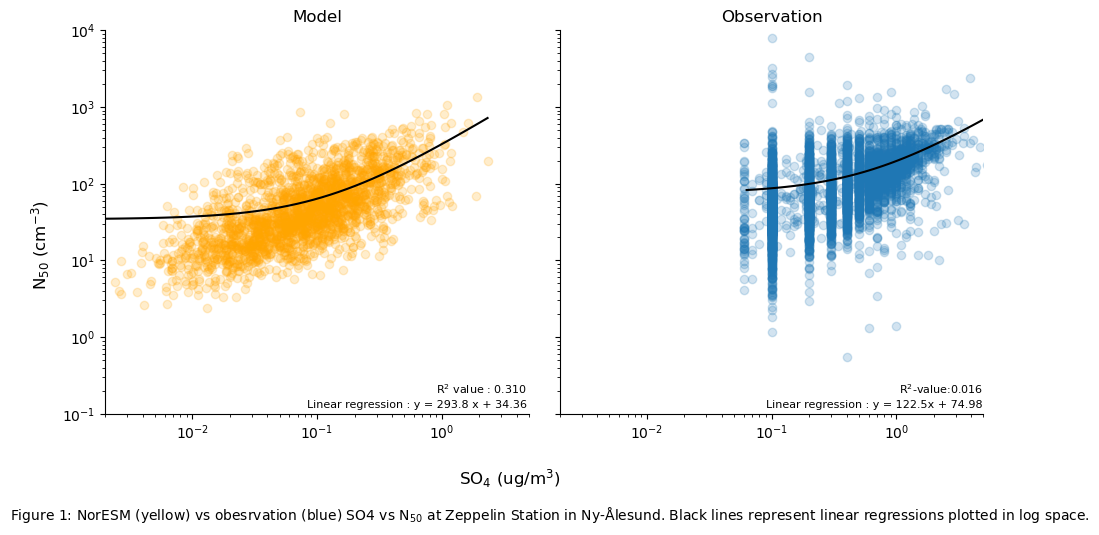

In [11]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SO4_Model','N50_Model']].dropna('time')
ax1.scatter(x=_dss['SO4_Model'], y=_dss['N50_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SO4_Model'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SO4_Model'].min()), np.log10(_dss['SO4_Model'].max()))
#print(p)
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 0.12, 'Linear regression : y = 293.8 x + 34.36' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50_Model'])
r_sq = model.score(x, _dss['N50_Model'])
#print(f"coefficient of determination: {r_sq}")
ax1.text(0.9, 0.18, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_ylim(0.1,10000)
ax1.set_xlim(0.002,5)
ax1.set_yscale ('log')
ax1.set_xscale ('log')
#ax1.set_xlabel('SO4 ug/m$^3$')
#ax1.set_ylabel('N50')
ax1.set_title(f'Model')

_dss = ALLDATA[['SO4','N50']].dropna('time')
ax2.scatter(x=_dss['SO4'], y=_dss['N50'], alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SO4'], _dss['N50'], 1)
p = np.poly1d(z)
x= np.logspace(-1.2, np.log10(_dss['SO4'].max()))
#print(p)
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.09, 0.12, 'Linear regression : y = 122.5x + 74.98' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50'])
r_sq = model.score(x, _dss['N50'])
#print(r_sq)
ax2.text(1.05, 0.18, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(0.1,10000)
ax2.set_xlim(0.002,5)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
#plt.xlabel('SO4 ug/m$^3$')
#plt.ylabel('N50 ')
ax2.set_title(f'Observation')
#f.suptitle('Influence of SO4 on N$_{50}$ at Zeppelin', fontsize=16)
f.supxlabel('SO$_4$ (ug/m$^3$)')
f.supylabel('N$_{50}$ (cm$^{-3}$)')

f.text(0, -0.05,
         'Figure 1: NorESM (yellow) vs obesrvation (blue) SO4 vs N$_{50}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)

Figure 2 shows the same relationship as figure 1 for SO4 now plotted against N100. In this figure, the slopes of both linear regressions appear to be very similar. Both when comparing sulphate to N50 as well as N100, the R-squared values of the Model data is far better than the observation data meaning a better fit between the two variables.

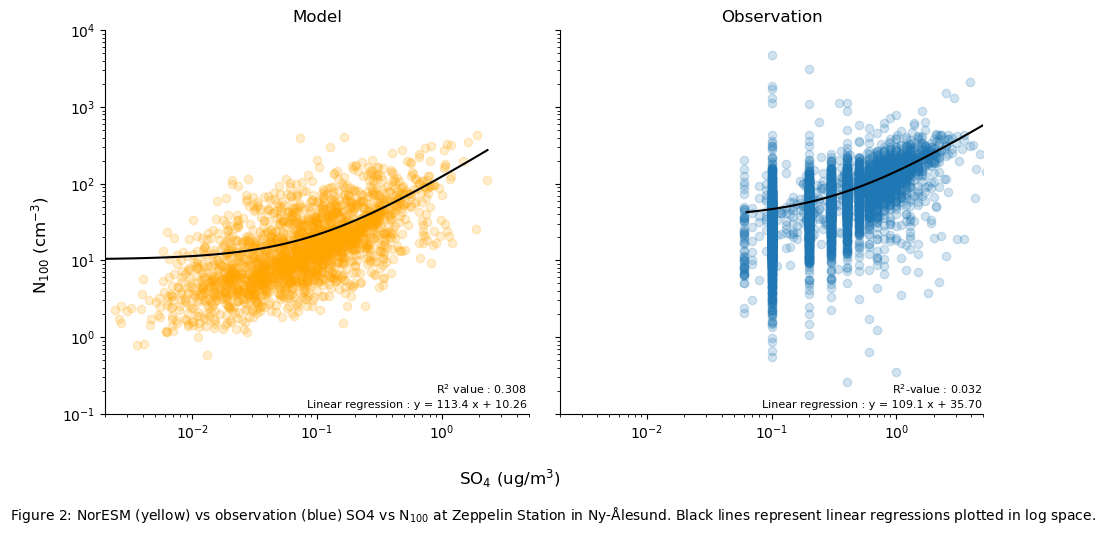

In [107]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))

_dss = ALLDATA[['SO4_Model','N100_Model']].dropna('time')
ax1.scatter(x=_dss['SO4_Model'], y=_dss['N100_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SO4_Model'], _dss['N100_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SO4_Model'].min()), np.log10(_dss['SO4_Model'].max()))
#print(p)
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 0.12, 'Linear regression : y = 113.4 x + 10.26' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100_Model'])
r_sq = model.score(x, _dss['N100_Model'])
#print(f"coefficient of determination: {r_sq}")
ax1.text(0.9, 0.18, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_ylim(0.1,10000)
ax1.set_xlim(0.002,5)
ax1.set_yscale ('log')
ax1.set_xscale ('log')
#ax1.set_xlabel('SO4 ug/m$^3$')
#ax1.set_ylabel('N100')
ax1.set_title(f'Model')

_dss = ALLDATA[['SO4','N100']].dropna('time')
ax2.scatter(x=_dss['SO4'], y=_dss['N100'], alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SO4'], _dss['N100'], 1)
p = np.poly1d(z)
x= np.logspace(-1.2, np.log10(_dss['SO4'].max()))
#print(p)
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.084, 0.12, 'Linear regression : y = 109.1 x + 35.70' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100'])
r_sq = model.score(x, _dss['N100'])
#print(r_sq)
ax2.text(0.92, 0.18, f"R$^2$-value : {r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(0.1,10000)
ax2.set_xlim(0.002,5)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
#plt.xlabel('SO4 ug/m$^3$')
#plt.ylabel('N100 ')
ax2.set_title(f'Observation')
#f.suptitle('Influence of SO4 on N$_{100}$ at Zeppelin', fontsize=16)
f.supxlabel('SO$_4$ (ug/m$^3$)')
f.supylabel('N$_{100}$ (cm$^{-3}$)')
f.text(0, -0.05,
         'Figure 2: NorESM (yellow) vs observation (blue) SO4 vs N$_{100}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')




sns.despine(f)

As seasalt is one of the largest sources of aerosols, it might also have an important role in the model's sources of N50 and N100 values. Figure 3 presents the relationship between the concentrations of sea salt and N50 in both the model (yellow) and observations (blue). The model shows a 6.0 times lower relationship of N50 particles to sea salt than is present in the observation data. For the observation data there are most data points clustered around median concentrations of Sea salt (0.14 ug/m3). In the model data however, the spread of the sea salt concentrations is far higher. Striation of the observation data at low concentrations is present.

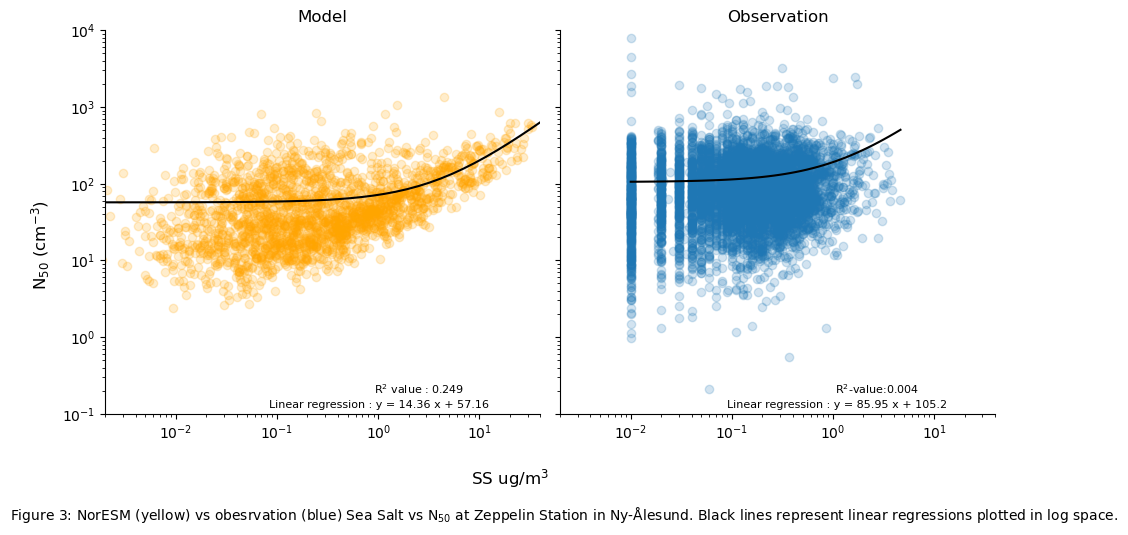

In [13]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SS_Model','N50_Model']].dropna('time')
ax1.scatter(x=_dss['SS_Model'], y=_dss['N50_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SS_Model'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SS_Model'].min()), np.log10(_dss['SS_Model'].max()))
#print(p)
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 0.12, 'Linear regression : y = 14.36 x + 57.16' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50_Model'])
r_sq = model.score(x, _dss['N50_Model'])
#print(f"coefficient of determination: {r_sq}")
ax1.text(0.9, 0.18, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_ylim(0.1,10000)
ax1.set_xlim(0.002,40)
ax1.set_yscale ('log')
ax1.set_xscale ('log')
#ax1.set_xlabel('SS ug/m$^3$')
#ax1.set_ylabel('N50')
ax1.set_title(f'Model')

_dss = ALLDATA[['SS','N50']].dropna('time')
ax2.scatter(x=_dss['SS'], y=_dss['N50'], alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SS'], _dss['N50'], 1)
p = np.poly1d(z)
x= np.logspace(-2, np.log10(_dss['SS'].max()))
#print(p)
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.09, 0.12, 'Linear regression : y = 85.95 x + 105.2' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50'])
r_sq = model.score(x, _dss['N50'])
#print(r_sq)
ax2.text(1.05, 0.18, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(0.1,10000)
ax2.set_xlim(0.002,40)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
#plt.xlabel('SS ug/m$^3$')
#plt.ylabel('N50 ')
ax2.set_title(f'Observation')
#f.suptitle('Influence of SS on N$_{50}$ at Zeppelin', fontsize=16)
f.supxlabel('SS ug/m$^3$')
f.supylabel('N$_{50}$ (cm$^{-3}$)')

f.text(0, -0.05,
         'Figure 3: NorESM (yellow) vs obesrvation (blue) Sea Salt vs N$_{50}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')



sns.despine(f)

Figure 4 shows sea salt concentrations against N100 concentrations in NorESM and observations. Since Sea salt concentrations are being plotted here as well as in figure 3, the same striation at low concentrations and general clustering around median concentrations (0.14 ug/m3). 

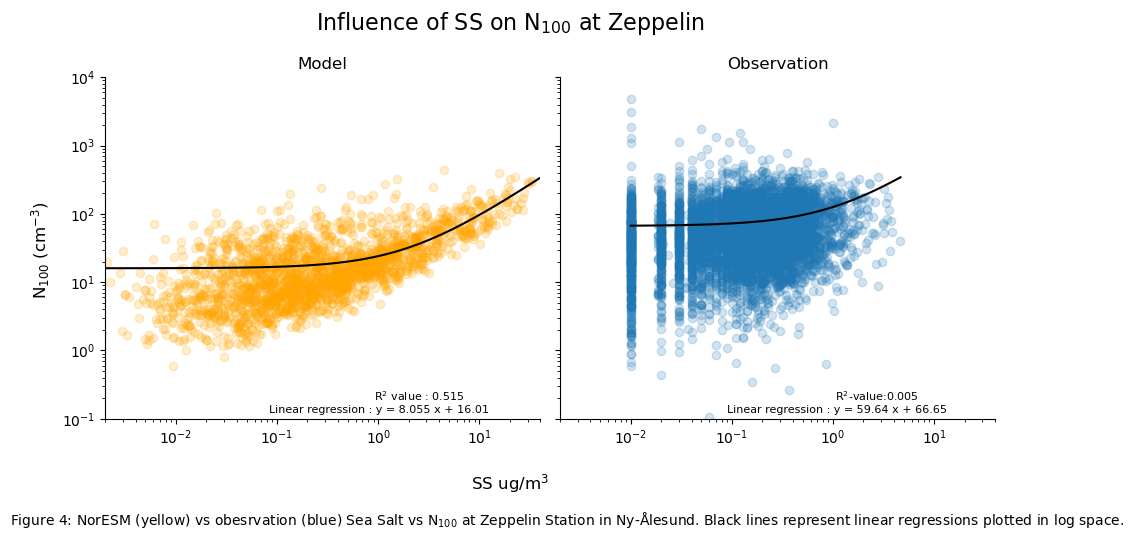

In [14]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SS_Model','N100_Model']].dropna('time')
ax1.scatter(x=_dss['SS_Model'], y=_dss['N100_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SS_Model'], _dss['N100_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SS_Model'].min()), np.log10(_dss['SS_Model'].max()))
#print(p)
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 0.12, 'Linear regression : y = 8.055 x + 16.01' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100_Model'])
r_sq = model.score(x, _dss['N100_Model'])
#print(f"coefficient of determination: {r_sq}")
ax1.text(0.9, 0.18, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_ylim(0.1,10000)
ax1.set_xlim(0.002,40)
ax1.set_yscale ('log')
ax1.set_xscale ('log')
#ax1.set_xlabel('SS ug/m$^3$')
#ax1.set_ylabel('N100')
ax1.set_title(f'Model')

_dss = ALLDATA[['SS','N100']].dropna('time')
ax2.scatter(x=_dss['SS'], y=_dss['N100'], alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SS'], _dss['N100'], 1)
p = np.poly1d(z)
x= np.logspace(-2, np.log10(_dss['SS'].max()))
#print(p)
ax2.plot( x, p(x), c = 'black', )
ax2.text(0.09, 0.12, 'Linear regression : y = 59.64 x + 66.65' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SS']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N100'])
r_sq = model.score(x, _dss['N100'])
#print(r_sq)
ax2.text(1.05, 0.18, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(0.1,10000)
ax2.set_xlim(0.002,40)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
#plt.xlabel('SS ug/m$^3$')
#plt.ylabel('N100 ')
ax2.set_title(f'Observation')
f.suptitle('Influence of SS on N$_{100}$ at Zeppelin', fontsize=16)
f.supxlabel('SS ug/m$^3$')
f.supylabel('N$_{100}$ (cm$^{-3}$)')
f.text(0, -0.05,
         'Figure 4: NorESM (yellow) vs obesrvation (blue) Sea Salt vs N$_{100}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')


sns.despine(f)

### 3.2 Accuracy of NorESM

In order to determine how accurately NorESM models the conditions present in Zeppelin, each data variable was compared to the daily averages of the same date in the measurement data. In the sulphate, N50 and N100 concentrations, datapoints have a tendency to be below the 1:1 line. Sea salt concentrations appear to be above the 1:1 line. This same pattern is seen in the slopes of the linear regressions all falling below 1. For sea salt, most datapoints are above the 1:1 line and similarly the slope of the linear regression is above 1. It is good to note that the axes of the sulphate comparison scatterplot are have minima that are different by a magnitude of 2 orders. This is why the 1:1 line may look quite different from the other scatterplots.

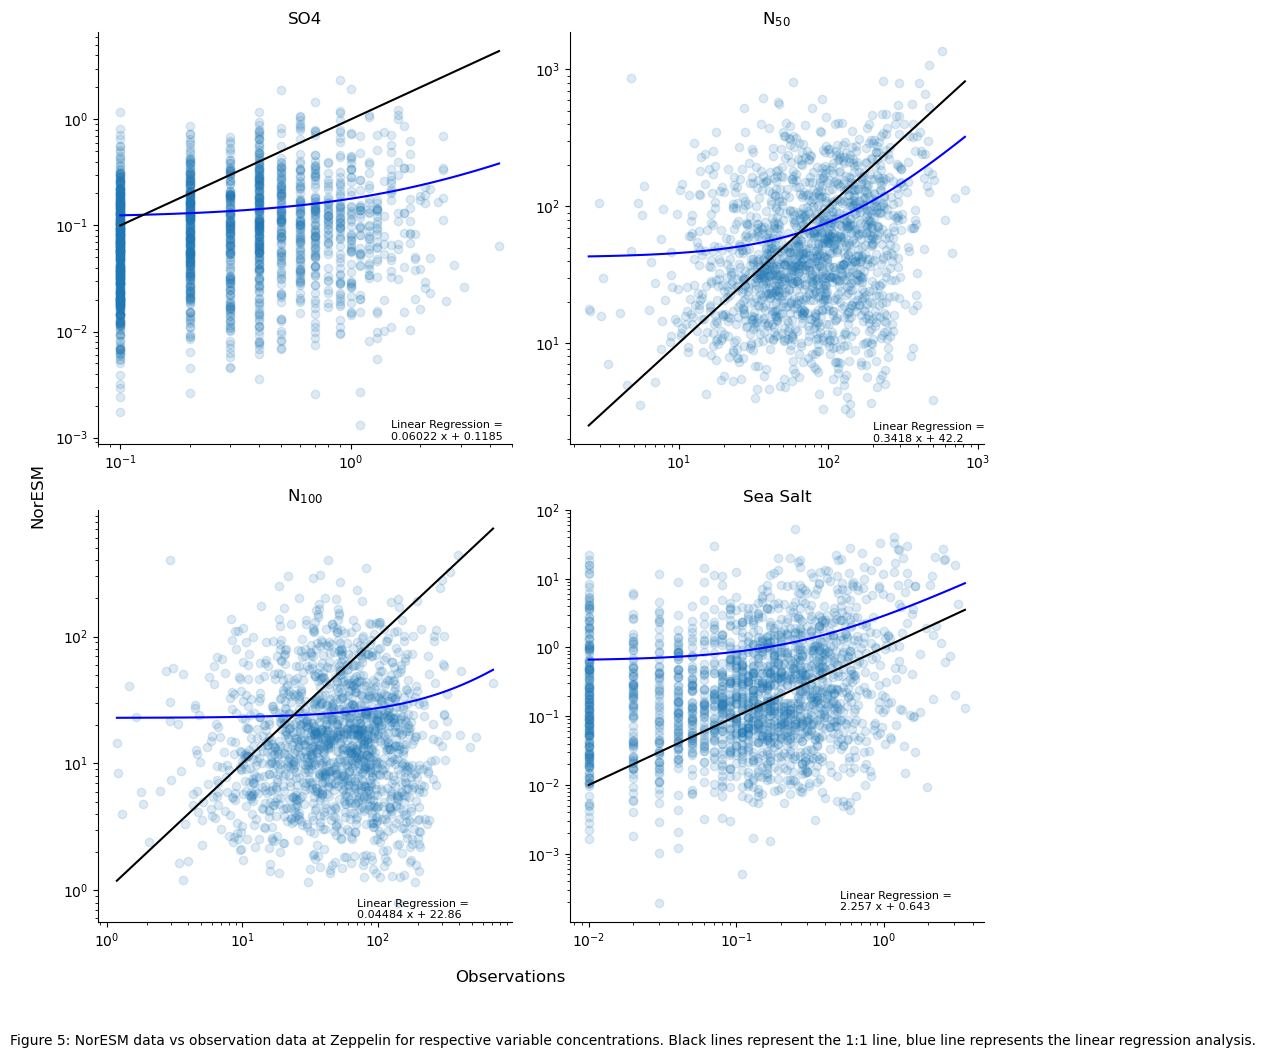

In [15]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout= True, figsize = (10,10))

ax1.scatter(x = ALLDATA['SO4'], y = ALLDATA['SO4_Model'],alpha = 0.15)
_dss = ALLDATA.to_dataframe().dropna()
z = np.polyfit(_dss['SO4'], _dss['SO4_Model'], 1)
p = np.poly1d(z)
x= np.logspace(-1, np.log10(_dss['SO4'].max()))
ax1.plot( x, p(x), c = 'blue', )
ax1.plot( x, x, c = 'black', )
#print(p)
ax1.text(1.5, 0.00095, f"Linear Regression = {p}"  ,fontsize=8)

ax1.set_xlim(0.08,5)
ax1.set_title ('SO4')
ax1.set_yscale ('log')
ax1.set_xscale ('log')

ax2.scatter(x = ALLDATA['N50'], y = ALLDATA['N50_Model'],alpha = 0.15)
z = np.polyfit(_dss['N50'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['N50'].min()), np.log10(_dss['N50'].max()))
ax2.plot( x, p(x), c = 'blue', )
ax2.plot( x, x, c = 'black', )
#print(p)
ax2.text(200.0, 1.9, f"Linear Regression = {p}"  ,fontsize=8)

ax2.set_title ('N$_{50}$')
ax2.set_yscale ('log')
ax2.set_xscale ('log')

ax3.scatter(x = ALLDATA['N100'], y = ALLDATA['N100_Model'],alpha = 0.15)
z = np.polyfit(_dss['N100'], _dss['N100_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['N100'].min()), np.log10(_dss['N100'].max()))
ax3.plot( x, p(x), c = 'blue', )
ax3.plot( x, x, c = 'black', )
#print(p)
ax3.text(70.0, 0.6, f"Linear Regression = {p}"  ,fontsize=8)

ax3.set_title ('N$_{100}$')
ax3.set_yscale ('log')
ax3.set_xscale ('log')

ax4.scatter(x = ALLDATA['SS'], y = ALLDATA['SS_Model'],alpha = 0.15)
z = np.polyfit(_dss['SS'], _dss['SS_Model'], 1)
p = np.poly1d(z)
x= np.logspace(-2, np.log10(_dss['SS'].max()))
ax4.plot( x, p(x), c = 'blue', )
ax4.plot( x, x, c = 'black', )
#print(p)
ax4.text(0.5, 0.00015, f"Linear Regression = {p}"  ,fontsize=8)

ax4.set_title ('Sea Salt')
ax4.set_yscale ('log')
ax4.set_xscale ('log')

f.supxlabel('Observations')
f.supylabel('NorESM')
#f.suptitle('NorESM data against Observation data')
f.text(0, -0.05,
         'Figure 5: NorESM data vs observation data at Zeppelin for respective variable concentrations. Black lines represent the 1:1 line, blue line represents the linear regression analysis.')


sns.despine()

***

## 4. Discussion

Sulphate is important in making particles that are soluble allowing them to grow by allowing water to grow on them. We can see that the model also acknowledges the role of sulphate in new particle formation, however, it seems to overestimate the influence of sulphate's role. This is because whilst the slope of the model data for sulphate vs N100 is similar to that in the observation data (Figure 2), when including smaller particle sizes (N50) the slope of the model data is more than 2.5 times higher than that of the observation data (Figure 1). Additionally, the fairly good r-squared values of around 0.31 for the linear regression (given the complicated nature of particle formation), suggests that sulphate is a main reason for the trend seen in the model.

When analysing how the model represents sea salt, it would be expected for sea salt to have a larger influence on the N100 concentration given that sea salt particles are usually slightly larger. NorESM represents this quite accurately since the r-squared value of the linear regression increases from 0.249 to 0.515 when comparing sea salt to N50 and N100 respectively. It is curious however, that the difference between the slopes of the model and observation data increases as well when moving from N50 to N100. This means that despite the model correctly identifying sea salt's increased role in the formation of larger particles, it underestimates how many of these particles are being created. When looking at N100, this could due to NorESM producing too many large sea salt aerosols as this would result in a smaller number of particles whilst keeping the concentration of sodium (which is used as the proxy for sea salt particles) high.

Directly comparing NorESM values to observation values for each variable indicated that NorESM underestimated the concentrations of all variables with the exception of sea salt. For N100, this underestimation seems only slight as many of the datapoints seem to fall close to the 1:1 line. The fact that sea salt concentrations are overestimated could balance out the fact that this concentration is not spread out across enough particles. When it comes to CCN production, this could still be problematic as it would result in the correct number of particles, however these would be too large in diameter. Concentrations of N50 seem to be underestimated in the model which opposes the overstimation of sulphates role in new particle formation. This is due to the fact that, as seen in figure 4, low concentrations of sulphate are more accurately measured, whereas higher concentrations events are not as frequent as they should be. This means that despite the model creating too many small particles when sulphate is present, the lack of sulphate is more prevalent resulting in too few small particles overall.

It is important to note that a strong limitation of this investigation is the banded striation visible in most of the obesrvation data. This can be explained when plotting SO4 on its own, see supplementary figure 1. Despite the observation data being daily averages, the concentrations seem to become grouped into increments of 0.1 ug/m3 for SO4 and 0.01 ug/m3 for sea salt. This is likely a large reason for why the r-squared values are very low in the observation data as the concentrations that would be between these increments are not accurately measured, making it hard to determine the correlation and potential causality between variables.

## 5. Conclusion

Whilst NorESM does take many intricate processes into account that lead to the formation of aerosols and eventually clouds, many of these processes are not modelled as accurately as they could when looking at the Arctic. Whilst some of these errors balance out (eg. the overestimation of sea salt concentrations paired with the underestimation of particle numbers of sea salt aerosols), the eventual influence on cloud formation processes could be important as size and solubility of CCN's are crucial. Errors in particle sizes could have a knock-on effect with incorrect numbers of CCN's being activated, thereby influencing the optical properties of the clouds and changing the radiative balance for a very sensitive region of the earth.

## 6. Sources

## 7. Acknowledgements

Special thanks to Sara for lots of advice and guidance regarding coding and understanding of scientific background. Thank you to Michael Schulz and Paul Zieger for organizing this course which has already greatly increased my coding abilities, thereby aiding in any future projects of mine that include data processing of large datasets.

### 8. Supplementary

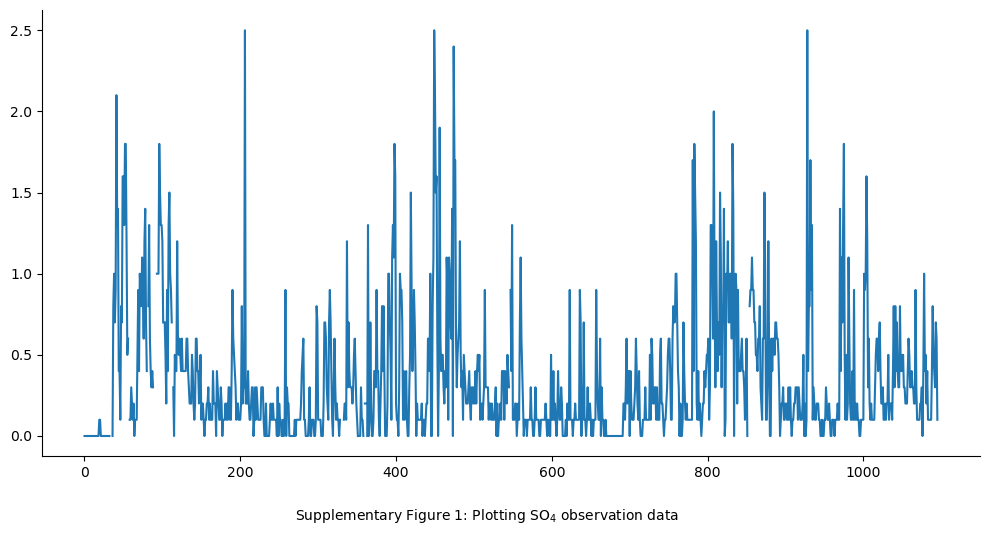

In [26]:
f, (ax1) = plt.subplots(1,tight_layout=True, figsize = (10,5))


#_dss = ALLDATA[['SO4_Model','N100_Model']].dropna('time')
ax1.plot(ALLDATA['SO4'].sel(time=slice('2015-01','2017-12')))

f.text(0.3, -0.05,
         'Supplementary Figure 1: Plotting SO$_4$ observation data')

sns.despine()

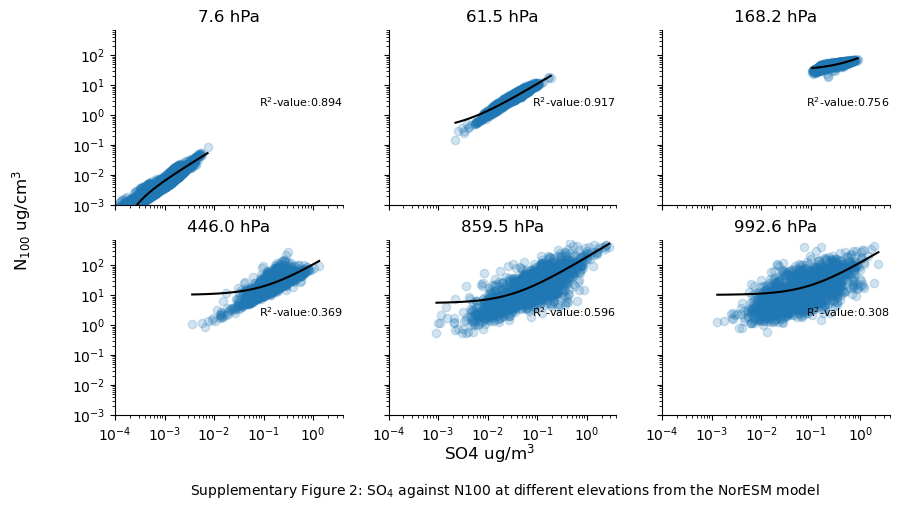

In [17]:
Levels = ds_daily.sel(location = 'Zeppelin').isel(lev= [-31,-25,-19,-13,-7,-1])
Levels = Levels.load()

fig, axs = plt.subplots(2,3, figsize = [10,5], sharex=True, sharey=True)

#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])

for lev, ax in zip(Levels['lev'], axs.flatten()):
    #print(lev)
    _dss = Levels.where(Levels['lev']==lev)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_Model'], y=_dss['N100'], alpha = 0.2 )
    z = np.polyfit(_dss['SO4_Model'], _dss['N100'], 1)
    p = np.poly1d(z)
    x= np.logspace(np.log10(_dss['SO4_Model'].min()), np.log10(_dss['SO4_Model'].max()))
    ax.plot( x, p(x), c = 'black', )
    #print(p)
    #ax.set_ylim ([7,100])
    #ax.set_xlim ([0.007,0.2])
    ax.set_ylim ([0.001,700])
    ax.set_xlim ([0.0001,4])
    
    ax.set_yscale ('log')
    ax.set_xscale ('log')
    ax.set_title(f'{lev.values:.1f} hPa')
    
    #Calculating R-Squared
    x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
    model = LinearRegression().fit (x, _dss['N100'])
    r_sq = model.score(x, _dss['N100'])
    ax.text(0.08, 2, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)
    #ax.text(0.3, 0.15, f"R$^2$-value:{r_sq}0.3f"  ,fontsize=8)

    
fig.supxlabel('SO4 ug/m$^3$')
fig.supylabel('N$_{100}$ ug/cm$^3$')

fig.text(0.2, -0.05,
         'Supplementary Figure 2: SO$_4$ against N100 at different elevations from the NorESM model')

sns.despine(fig)

## Removing bottom 14%

In [20]:
masked = ALLDATA.where(ALLDATA['SO4']>0.1)

<module 'seaborn' from '/srv/conda/envs/notebook/lib/python3.9/site-packages/seaborn/__init__.py'>

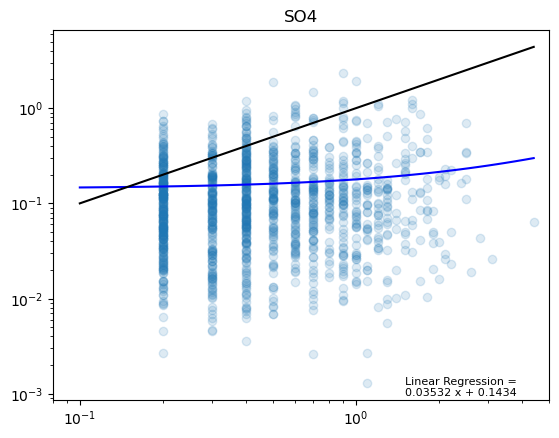

In [24]:
f,ax1 = plt.subplots()

ax1.scatter(x = masked['SO4'], y = masked['SO4_Model'],alpha = 0.15)
_dss = masked.to_dataframe().dropna()
z = np.polyfit(_dss['SO4'], _dss['SO4_Model'], 1)
p = np.poly1d(z)
x= np.logspace(-1, np.log10(_dss['SO4'].max()))
ax1.plot( x, p(x), c = 'blue', )
ax1.plot( x, x, c = 'black', )
#print(p)
ax1.text(1.5, 0.00095, f"Linear Regression = {p}"  ,fontsize=8)

ax1.set_xlim(0.08,5)
ax1.set_title ('SO4')
ax1.set_yscale ('log')
ax1.set_xscale ('log')
sns

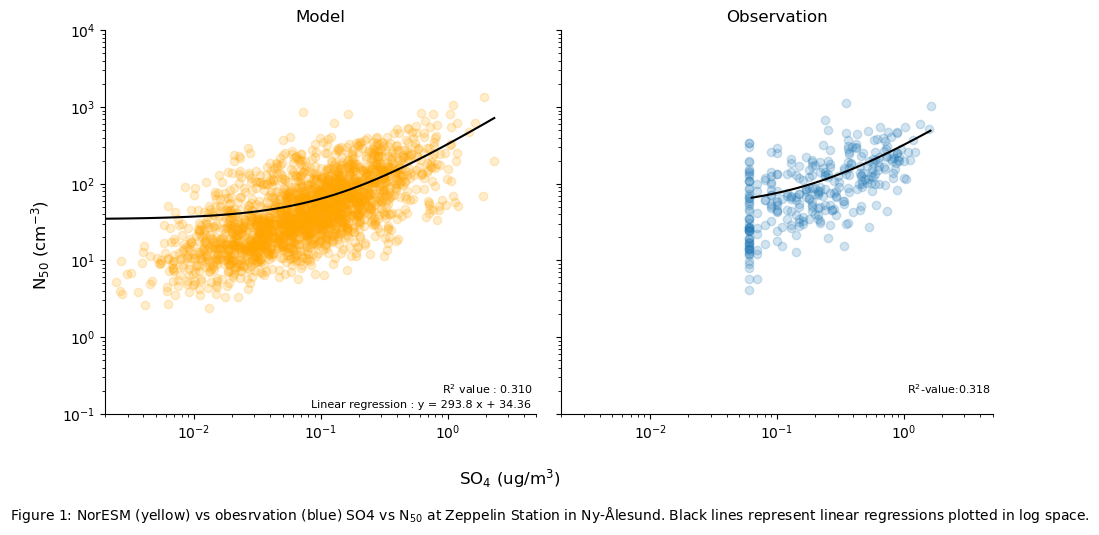

In [41]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = ALLDATA[['SO4_Model','N50_Model']].dropna('time')
ax1.scatter(x=_dss['SO4_Model'], y=_dss['N50_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SO4_Model'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SO4_Model'].min()), np.log10(_dss['SO4_Model'].max()))
#print(p)
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 0.12, 'Linear regression : y = 293.8 x + 34.36' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50_Model'])
r_sq = model.score(x, _dss['N50_Model'])
#print(f"coefficient of determination: {r_sq}")
ax1.text(0.9, 0.18, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_ylim(0.1,10000)
ax1.set_xlim(0.002,5)
ax1.set_yscale ('log')
ax1.set_xscale ('log')
#ax1.set_xlabel('SO4 ug/m$^3$')
#ax1.set_ylabel('N50')
ax1.set_title(f'Model')

_dss = ALLDATA[['SO4','N50']].dropna('time')
ax2.scatter(x=_dss['SO4'].sel(time=slice('2020-01','2022-12')), y=_dss['N50'].sel(time=slice('2020-01','2022-12')), alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SO4'].sel(time=slice('2020-01','2022-12')), _dss['N50'].sel(time=slice('2020-01','2022-12')), 1)
p = np.poly1d(z)
x= np.logspace(-1.2, np.log10(_dss['SO4'].sel(time=slice('2020-01','2022-12')).max()))
#print(p)
ax2.plot( x, p(x), c = 'black', )
#ax2.text(0.09, 0.12, 'Linear regression : y = 122.5x + 74.98' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4'].sel(time=slice('2020-01','2022-12'))]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50'].sel(time=slice('2020-01','2022-12')))
r_sq = model.score(x, _dss['N50'].sel(time=slice('2020-01','2022-12')))
#print(r_sq)
ax2.text(1.05, 0.18, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(0.1,10000)
ax2.set_xlim(0.002,5)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
#plt.xlabel('SO4 ug/m$^3$')
#plt.ylabel('N50 ')
ax2.set_title(f'Observation')
#f.suptitle('Influence of SO4 on N$_{50}$ at Zeppelin', fontsize=16)
f.supxlabel('SO$_4$ (ug/m$^3$)')
f.supylabel('N$_{50}$ (cm$^{-3}$)')

f.text(0, -0.05,
         'Figure 1: NorESM (yellow) vs obesrvation (blue) SO4 vs N$_{50}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)

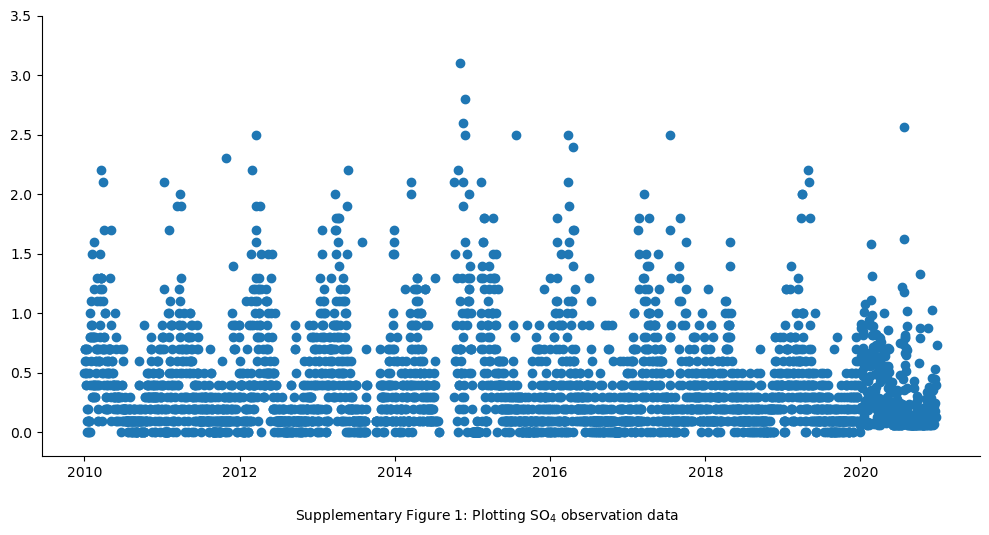

In [95]:
f, (ax1) = plt.subplots(1,tight_layout=True, figsize = (10,5))


#_dss = ALLDATA[['SO4_Model','N100_Model']].dropna('time')
ax1.scatter(x= ALLDATA['time'].sel(time=slice('2010-01','2022-12')), y = ALLDATA['SO4'].sel(time=slice('2010-01','2022-12')))
ax1.set_ylim(-0.2,3.5)

f.text(0.3, -0.05,
         'Supplementary Figure 1: Plotting SO$_4$ observation data')

sns.despine()

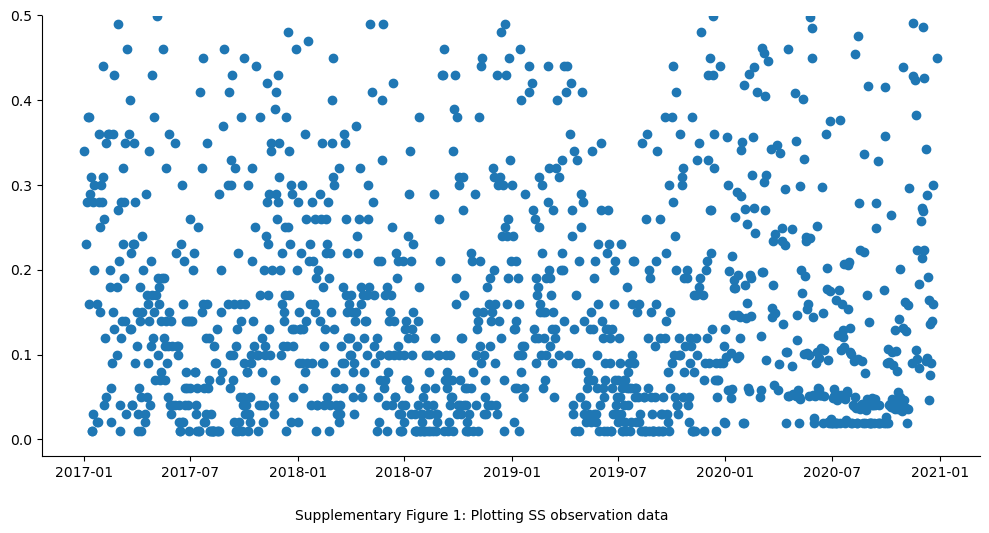

In [111]:
f, (ax1) = plt.subplots(1,tight_layout=True, figsize = (10,5))


#_dss = ALLDATA[['SO4_Model','N100_Model']].dropna('time')
ax1.scatter(x= ALLDATA['time'].sel(time=slice('2017-01','2022-12')), y = ALLDATA['SS'].sel(time=slice('2017-01','2022-12')))
ax1.set_ylim(-0.02,.5)

f.text(0.3, -0.05,
         'Supplementary Figure 1: Plotting SS observation data')

sns.despine()

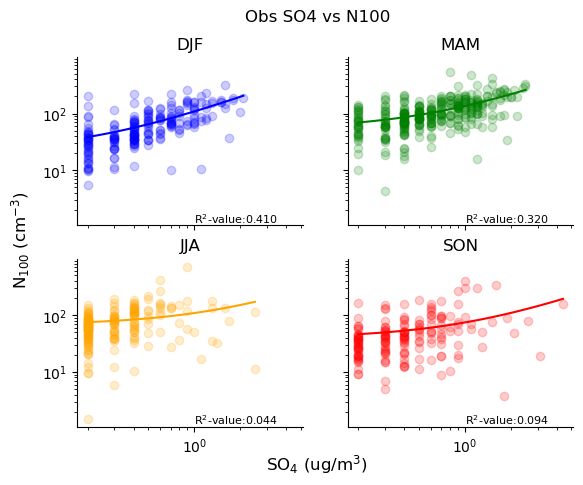

In [85]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    #print(seas)
    _dss = masked.where(masked['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4'], y=_dss['N100'],c= col, alpha = 0.2)
    z = np.polyfit(_dss['SO4'], _dss['N100'], 1)
    p = np.poly1d(z)
    x= np.logspace(-0.7, np.log10(_dss['SO4'].max()))
    ax.plot( x, p(x), c = col, )
    #print(p)
    #ax.set_ylim ([0,300])
    #ax.set_xlim ([0,2])
    ax.set_yscale ('log')
    ax.set_xscale ('log')
    ax.set_title(seas)
    
    #Calculating R-Squared
    x = np.array([_dss['SO4']]).reshape((-1, 1))
    model = LinearRegression().fit (x, _dss['N100'])
    r_sq = model.score(x, _dss['N100'])
    ax.text(1, 1.18, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)
    #ax.text(0.3, 0.15, f"R$^2$-value:{r_sq}0.3f"  ,fontsize=8)
    
fig.supxlabel('SO$_4$ (ug/m$^3$)')
fig.supylabel('N$_{100}$ (cm$^{-3}$)')
fig.suptitle('Obs SO4 vs N100')
    
sns.despine()

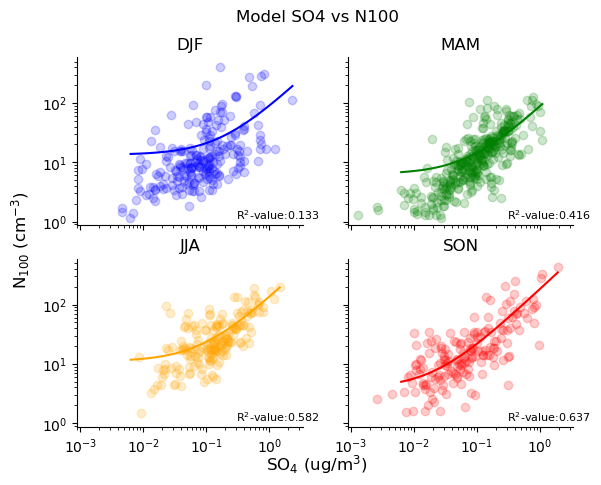

In [87]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    #print(seas)
    _dss = masked.where(masked['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_Model'], y=_dss['N100_Model'],c= col, alpha = 0.2)
    z = np.polyfit(_dss['SO4_Model'], _dss['N100_Model'], 1)
    p = np.poly1d(z)
    x= np.logspace(-2.2, np.log10(_dss['SO4_Model'].max()))
    ax.plot( x, p(x), c = col, )
    #print(p)
    #ax.set_ylim ([0,150])
    #ax.set_xlim ([0,1])
    ax.set_yscale ('log')
    ax.set_xscale ('log')
    ax.set_title(seas)
    
    #Calculating R-Squared
    x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
    model = LinearRegression().fit (x, _dss['N100_Model'])
    r_sq = model.score(x, _dss['N100_Model'])
    ax.text(0.3, 1.08, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)
    #ax.text(0.3, 0.15, f"R$^2$-value:{r_sq}0.3f"  ,fontsize=8)
    
fig.supxlabel('SO$_4$ (ug/m$^3$)')
fig.supylabel('N$_{100}$ (cm$^{-3}$)')
fig.suptitle('Model SO4 vs N100')
    
sns.despine()

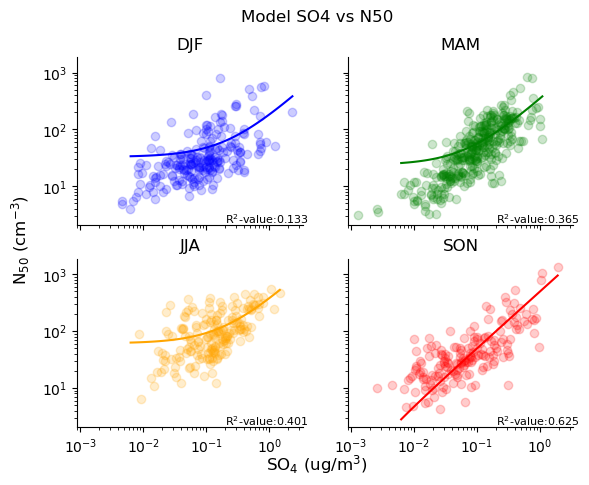

In [89]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    #print(seas)
    _dss = masked.where(masked['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4_Model'], y=_dss['N50_Model'],c= col, alpha = 0.2)
    z = np.polyfit(_dss['SO4_Model'], _dss['N50_Model'], 1)
    p = np.poly1d(z)
    x= np.logspace(-2.2, np.log10(_dss['SO4_Model'].max()))
    ax.plot( x, p(x), c = col, )
    #print(p)
    #ax.set_ylim ([0,300])
    #ax.set_xlim ([0,1])
    ax.set_yscale ('log')
    ax.set_xscale ('log')
    ax.set_title(seas)
    
    #Calculating R-Squared
    x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
    model = LinearRegression().fit (x, _dss['N50_Model'])
    r_sq = model.score(x, _dss['N50_Model'])
    ax.text(0.2, 2.18, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)
    #ax.text(0.3, 0.15, f"R$^2$-value:{r_sq}0.3f"  ,fontsize=8)
    
fig.supxlabel('SO$_4$ (ug/m$^3$)')
fig.supylabel('N$_{50}$ (cm$^{-3}$)')
fig.suptitle('Model SO4 vs N50')
    
sns.despine()

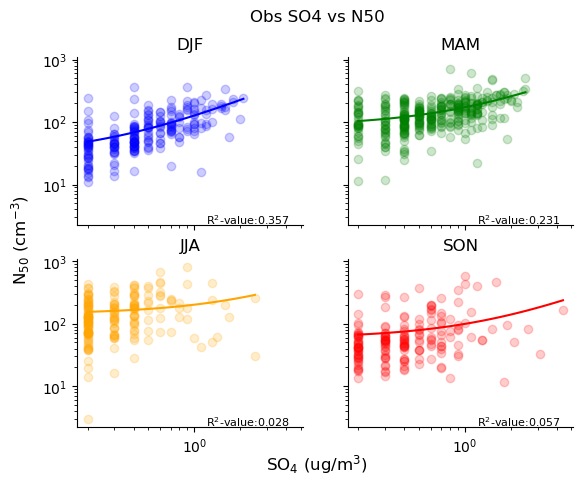

In [94]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    #print(seas)
    _dss = masked.where(masked['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4'], y=_dss['N50'],c= col, alpha = 0.2)
    z = np.polyfit(_dss['SO4'], _dss['N50'], 1)
    p = np.poly1d(z)
    x= np.logspace(-0.7, np.log10(_dss['SO4'].max()))
    ax.plot( x, p(x), c = col, )
    #print(p)
    #ax.set_ylim ([0,300])
    #ax.set_xlim ([0,1])
    ax.set_yscale ('log')
    ax.set_xscale ('log')
    ax.set_title(seas)
    
    #Calculating R-Squared
    x = np.array([_dss['SO4']]).reshape((-1, 1))
    model = LinearRegression().fit (x, _dss['N50'])
    r_sq = model.score(x, _dss['N50'])
    ax.text(1.2, 2.30, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)
    #ax.text(0.3, 0.15, f"R$^2$-value:{r_sq}0.3f"  ,fontsize=8)
    
fig.supxlabel('SO$_4$ (ug/m$^3$)')
fig.supylabel('N$_{50}$ (cm$^{-3}$)')
fig.suptitle('Obs SO4 vs N50')
    
sns.despine()

In [96]:
dsmf_S2012

<xarray.Dataset>
Dimensions:                                      (time: 2192, tbnds: 2,
                                                  metadata_time: 6,
                                                  chloride_qc_flags: 1,
                                                  nitrate_ug_per_m3_qc_flags: 1,
                                                  sulphate_corrected_ug_per_m3_qc_flags: 1,
                                                  nitric_acid_qc_flags: 1,
                                                  ...
                                                  sum_nitric_acid_and_nitrate_qc_flags: 1,
                                                  ammonium_ug_per_m3_qc_flags: 1,
                                                  ammonia_qc_flags: 1,
                                                  potassium_qc_flags: 1,
                                                  calcium_qc_flags: 1,
                                                  magnesium_qc_flags: 1)
Coordinates:
  * time                                         (time) datetime64[ns] 2012-0...
  * metadata_time                                (metadata_time) datetime64[ns] ...
Dimensions without coordinates: tbnds, chloride_qc_flags,
                                nitrate_ug_per_m3_qc_flags,
                                sulphate_corrected_ug_per_m3_qc_flags,
                                nitric_acid_qc_flags,
                                sulphate_total_ug_S_per_m3_qc_flags,
                                sodium_qc_flags, ammonium_ug_N_per_m3_qc_flags,
                                ...
                                sulphate_corrected_ug_S_per_m3_qc_flags,
                                sum_ammonia_and_ammonium_qc_flags,
                                sum_nitric_acid_and_nitrate_qc_flags,
                                ammonium_ug_per_m3_qc_flags, ammonia_qc_flags,
                                potassium_qc_flags, calcium_qc_flags,
                                magnesium_qc_flags
Data variables: (12/53)
    time_bnds                                    (time, tbnds) datetime64[ns] ...
    metadata_time_bnds                           (metadata_time, tbnds) datetime64[ns] ...
    chloride_qc                                  (chloride_qc_flags, time) float64 ...
    nitrate_ug_per_m3_qc                         (nitrate_ug_per_m3_qc_flags, time) float64 ...
    ammonium_ug_per_m3                           (time) float64 ...
    sulphate_corrected_ug_S_per_m3               (time) float64 ...
    ...                                           ...
    ammonia_qc                                   (ammonia_qc_flags, time) float64 ...
    calcium                                      (time) float64 ...
    magnesium                                    (time) float64 ...
    potassium_qc                                 (potassium_qc_flags, time) float64 ...
    calcium_qc                                   (calcium_qc_flags, time) float64 ...
    magnesium_qc                                 (magnesium_qc_flags, time) float64 ...
Attributes: (12/90)
    Conventions:                       CF-1.8, ACDD-1.3
    featureType:                       timeSeries
    title:                             Ground based in situ observations of f...
    keywords:                          mass_concentration_of_chloride_in_dry_...
    id:                                NO0042G.20120101070000.20210421112338....
    naming_authority:                  EBAS
    ...                                ...
    geospatial_lat_units:              degrees_north
    geospatial_lon_units:              degrees_east
    comment:                           {\n    "Data definition": "EBAS_1.1", ...
    standard_name_vocabulary:          CF-1.7, ACDD-1.3
    history:                           None
    creator_url:                       ebas.nilu.no

In [97]:
weekly = ALLDATA.resample(time = 'w').mean('time')

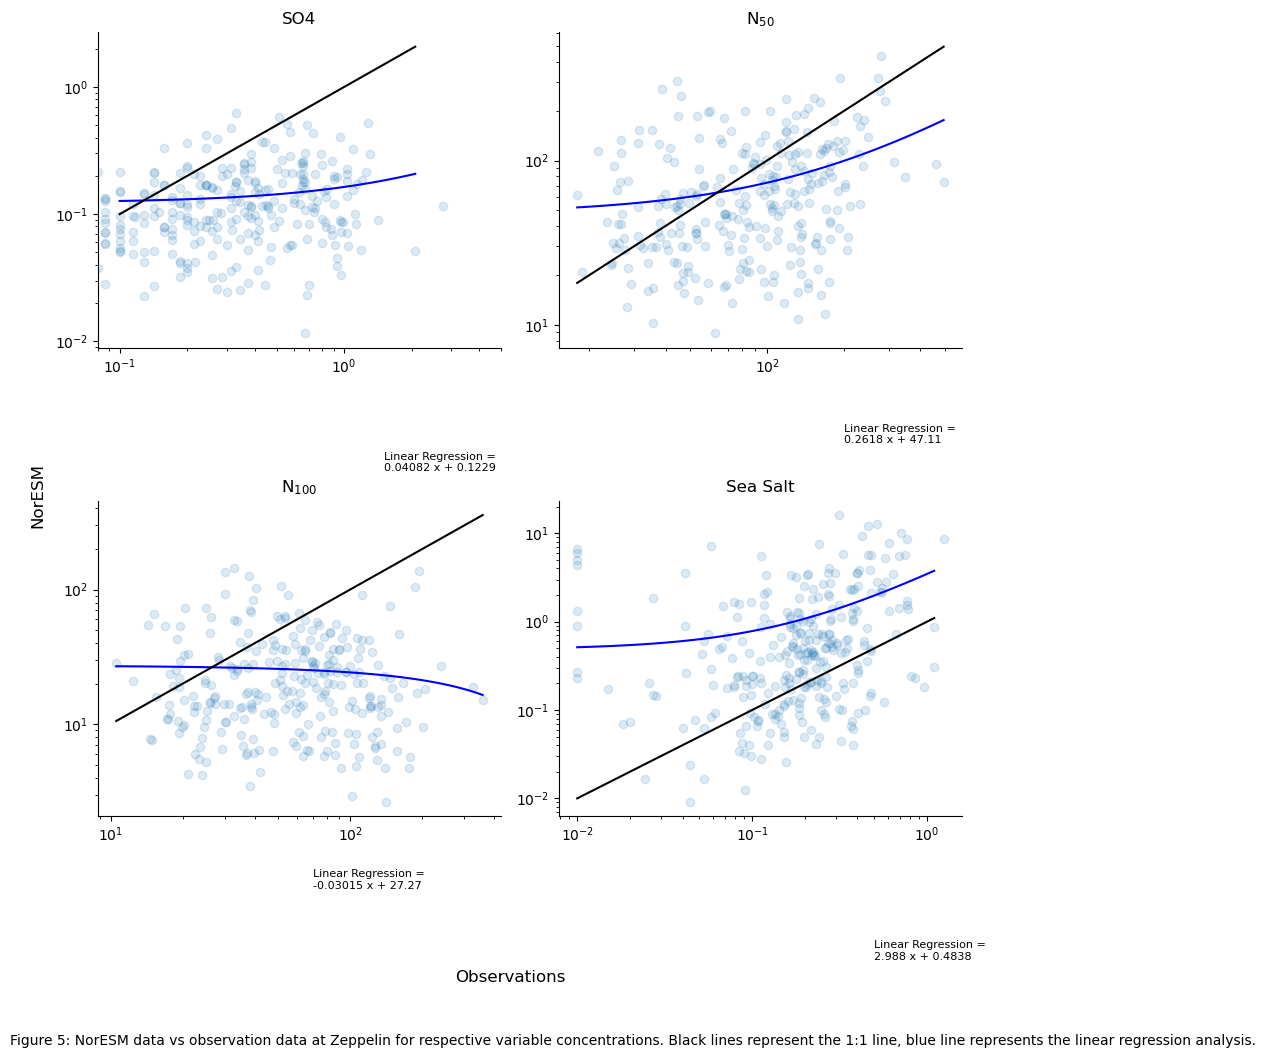

In [98]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, tight_layout= True, figsize = (10,10))

ax1.scatter(x = weekly['SO4'], y = weekly['SO4_Model'],alpha = 0.15)
_dss = weekly.to_dataframe().dropna()
z = np.polyfit(_dss['SO4'], _dss['SO4_Model'], 1)
p = np.poly1d(z)
x= np.logspace(-1, np.log10(_dss['SO4'].max()))
ax1.plot( x, p(x), c = 'blue', )
ax1.plot( x, x, c = 'black', )
#print(p)
ax1.text(1.5, 0.00095, f"Linear Regression = {p}"  ,fontsize=8)

ax1.set_xlim(0.08,5)
ax1.set_title ('SO4')
ax1.set_yscale ('log')
ax1.set_xscale ('log')

ax2.scatter(x = weekly['N50'], y = weekly['N50_Model'],alpha = 0.15)
z = np.polyfit(_dss['N50'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['N50'].min()), np.log10(_dss['N50'].max()))
ax2.plot( x, p(x), c = 'blue', )
ax2.plot( x, x, c = 'black', )
#print(p)
ax2.text(200.0, 1.9, f"Linear Regression = {p}"  ,fontsize=8)

ax2.set_title ('N$_{50}$')
ax2.set_yscale ('log')
ax2.set_xscale ('log')

ax3.scatter(x = weekly['N100'], y = weekly['N100_Model'],alpha = 0.15)
z = np.polyfit(_dss['N100'], _dss['N100_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['N100'].min()), np.log10(_dss['N100'].max()))
ax3.plot( x, p(x), c = 'blue', )
ax3.plot( x, x, c = 'black', )
#print(p)
ax3.text(70.0, 0.6, f"Linear Regression = {p}"  ,fontsize=8)

ax3.set_title ('N$_{100}$')
ax3.set_yscale ('log')
ax3.set_xscale ('log')

ax4.scatter(x = weekly['SS'], y = weekly['SS_Model'],alpha = 0.15)
z = np.polyfit(_dss['SS'], _dss['SS_Model'], 1)
p = np.poly1d(z)
x= np.logspace(-2, np.log10(_dss['SS'].max()))
ax4.plot( x, p(x), c = 'blue', )
ax4.plot( x, x, c = 'black', )
#print(p)
ax4.text(0.5, 0.00015, f"Linear Regression = {p}"  ,fontsize=8)

ax4.set_title ('Sea Salt')
ax4.set_yscale ('log')
ax4.set_xscale ('log')

f.supxlabel('Observations')
f.supylabel('NorESM')
#f.suptitle('NorESM data against Observation data')
f.text(0, -0.05,
         'Figure 5: NorESM data vs observation data at Zeppelin for respective variable concentrations. Black lines represent the 1:1 line, blue line represents the linear regression analysis.')


sns.despine()

In [102]:
weekly['season'] = weekly['time.season']

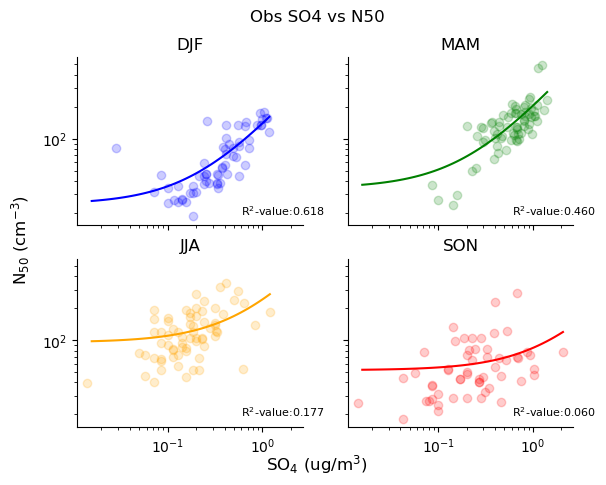

In [110]:
fig, axs = plt.subplots(2,2, sharex=True, sharey=True)
#ax.set_ylim ([0,750])
#ax.set_xlim ([0,1.2])



for seas, ax, col in zip(['DJF','MAM','JJA','SON'], axs.flatten(),['blue','green','orange','red']):
    #print(seas)
    _dss = weekly.where(weekly['season']==seas)
    _dss = _dss.to_dataframe().dropna()
    ax.scatter(x=_dss['SO4'], y=_dss['N50'],c= col, alpha = 0.2)
    z = np.polyfit(_dss['SO4'], _dss['N50'], 1)
    p = np.poly1d(z)
    x= np.logspace(-1.8, np.log10(_dss['SO4'].max()))
    ax.plot( x, p(x), c = col, )
    #print(p)
    #ax.set_ylim ([0,300])
    #ax.set_xlim ([0,1])
    ax.set_yscale ('log')
    ax.set_xscale ('log')
    ax.set_title(seas)
    
    #Calculating R-Squared
    x = np.array([_dss['SO4']]).reshape((-1, 1))
    model = LinearRegression().fit (x, _dss['N50'])
    r_sq = model.score(x, _dss['N50'])
    ax.text(0.6, 19, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)
    #ax.text(0.3, 0.15, f"R$^2$-value:{r_sq}0.3f"  ,fontsize=8)
    
fig.supxlabel('SO$_4$ (ug/m$^3$)')
fig.supylabel('N$_{50}$ (cm$^{-3}$)')
fig.suptitle('Obs SO4 vs N50')
    
sns.despine()

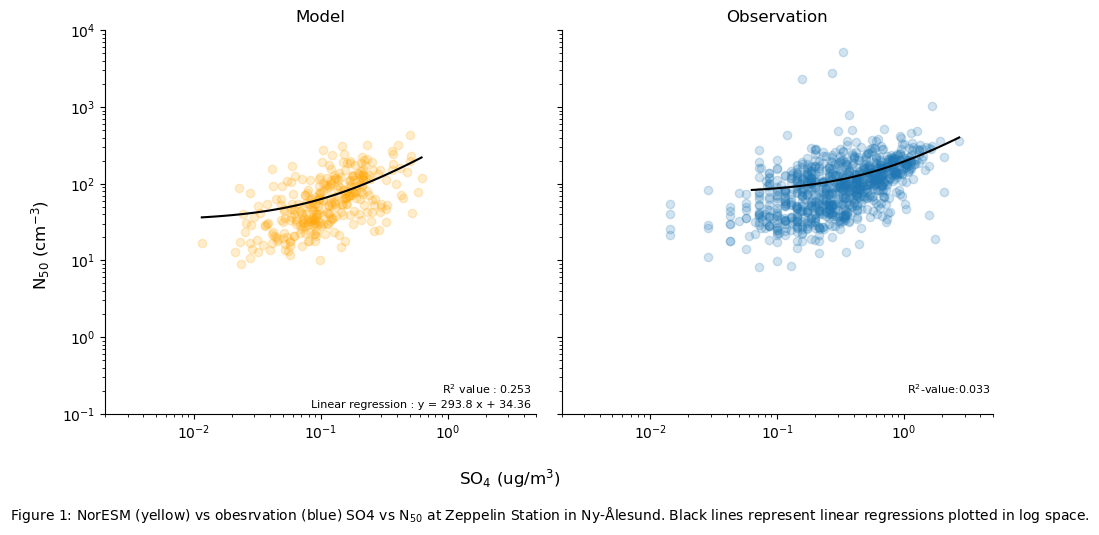

In [106]:
f, (ax1, ax2) = plt.subplots(1,2,tight_layout=True, sharey=True, sharex=True, figsize = (10,5))


_dss = weekly[['SO4_Model','N50_Model']].dropna('time')
ax1.scatter(x=_dss['SO4_Model'], y=_dss['N50_Model'],c='orange',alpha = 0.2)

#Linear regression
z = np.polyfit(_dss['SO4_Model'], _dss['N50_Model'], 1)
p = np.poly1d(z)
x= np.logspace(np.log10(_dss['SO4_Model'].min()), np.log10(_dss['SO4_Model'].max()))
#print(p)
ax1.plot( x, p(x), c = 'black', )
ax1.text(0.083, 0.12, 'Linear regression : y = 293.8 x + 34.36' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4_Model']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50_Model'])
r_sq = model.score(x, _dss['N50_Model'])
#print(f"coefficient of determination: {r_sq}")
ax1.text(0.9, 0.18, f'R$^2$ value : {r_sq:0.3f}' ,fontsize=8)

ax1.set_ylim(0.1,10000)
ax1.set_xlim(0.002,5)
ax1.set_yscale ('log')
ax1.set_xscale ('log')
#ax1.set_xlabel('SO4 ug/m$^3$')
#ax1.set_ylabel('N50')
ax1.set_title(f'Model')

_dss = weekly[['SO4','N50']].dropna('time')
ax2.scatter(x=_dss['SO4'], y=_dss['N50'], alpha = 0.2 )

#Linear regression
z = np.polyfit(_dss['SO4'], _dss['N50'], 1)
p = np.poly1d(z)
x= np.logspace(-1.2, np.log10(_dss['SO4'].max()))
#print(p)
ax2.plot( x, p(x), c = 'black', )
#ax2.text(0.09, 0.12, 'Linear regression : y = 122.5x + 74.98' ,fontsize=8)

#Calculating R-Squared
x = np.array([_dss['SO4']]).reshape((-1, 1))
model = LinearRegression().fit (x, _dss['N50'])
r_sq = model.score(x, _dss['N50'])
#print(r_sq)
ax2.text(1.05, 0.18, f"R$^2$-value:{r_sq:.3f}"  ,fontsize=8)

ax2.set_ylim(0.1,10000)
ax2.set_xlim(0.002,5)
ax2.set_yscale ('log')
ax2.set_xscale ('log')
#plt.xlabel('SO4 ug/m$^3$')
#plt.ylabel('N50 ')
ax2.set_title(f'Observation')
#f.suptitle('Influence of SO4 on N$_{50}$ at Zeppelin', fontsize=16)
f.supxlabel('SO$_4$ (ug/m$^3$)')
f.supylabel('N$_{50}$ (cm$^{-3}$)')

f.text(0, -0.05,
         'Figure 1: NorESM (yellow) vs obesrvation (blue) SO4 vs N$_{50}$ at Zeppelin Station in Ny-Ålesund. Black lines represent linear regressions plotted in log space.')

sns.despine(f)